In [33]:
import re
import string
import joblib
from sklearn.naive_bayes import MultinomialNB

import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline

In [2]:
# list of stopwords
stpwrd = nltk.corpus.stopwords.words('english')

lemmatizer = WordNetLemmatizer()

In [3]:
#read input from historical data into dataframe
data_df = pd.read_excel('/Users/jghosh2/Documents/my-notebook/L1 triage POC/data/Updated-JIRA_DUMP_Mar_2020_March_2022_Sourabh.xlsx',usecols=['Summary','Description','Component'])
data_df['Summary']=data_df['Summary'].astype(str)
data_df['Description']=data_df['Description'].astype(str)
data_df.dropna()
#choose sample data from entire data
data_df = data_df.sample(frac=1, random_state=42)

In [4]:
data_df.shape

(44513, 3)

In [5]:
def preprocess_text(message):
    # To handle np.nan 
    if isinstance(message, float):
        return None
    
    #lowering and removing punctuation
    message = re.sub(r'[^\w\s]','', message.lower())
    
    #removing the numerical values and working only with text values
    message = re.sub('[^a-zA-Z]', " ", message )
    
    #lemmatizing the text
    message =  " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(message) if w not in string.punctuation])
    
    # after preprocessing if message is empty string 
    if not message:
        message = None
        
    return message

In [10]:


# concatenate features into single corpus
data_df['text'] = data_df['Summary'].astype('str') + " " + data_df['Description'].astype('str')

# preprocessing steps for text data
data_df['processed_text'] = data_df['text'].apply(preprocess_text)

# drop rows which became NULL after preprocessing
data_df = data_df.dropna(how='any')
data_df=data_df.drop_duplicates(subset=['processed_text','Component'],keep='first')
    

In [11]:
df = data_df.dropna(how='any', subset=['Component'])
df.shape

(40255, 5)

In [12]:
# distribution of Merchants
df['Component'].value_counts()

Coupa_access_request         4025
Oracle_ap                    3065
OTM                          2798
TrinTech                     2726
Coupa                        2454
                             ... 
Coupa_invoice_integration      34
Sailpoint                      32
Oracle_login                   32
FDS                            28
Enhancement Request             6
Name: Component, Length: 61, dtype: int64

In [56]:
df

,Summary,Description,Component,text,processed_text
15538,ATG PO# 852279 for HYPERTECHNOLOGIE CIARA INC,"Hi Team, Can you please provide a pdf copy o...",Oracle_scm,ATG PO# 852279 for HYPERTECHNOLOGIE CIARA INC ...,atg po for hypertechnologie ciara inc hi team ...
7267,IC Relationship Setup - (Share Capital) Novemb...,"Hi FinTech Team,\n\n\n\n\n\nCould you please s...",Oracle_agis,IC Relationship Setup - (Share Capital) Novemb...,ic relationship setup share capital november h...
14528,JSON 210 ERRORS - TRICOR BRAUN,== Created by JEMH via e-mail from: <POKLI@KL...,B2B,JSON 210 ERRORS - TRICOR BRAUN == Created by J...,json error tricor braun created by jemh via em...
34155,Request to Create POs for Another Entity,PO Creator: shauna@uber.com \n Manager: \n De...,Coupa,Request to Create POs for Another Entity PO Cr...,request to create po for another entity po cre...
31983,UBER B2B Customer Process Status Report,== Created by JEMH via e-mail from: <oracle-w...,B2B,UBER B2B Customer Process Status Report == Cre...,uber b b customer process status report create...
...,...,...,...,...,...
6265,Payment terms,"Hi Team,\n\n\nPlease revise the payment terms ...",Coupa_po,"Payment terms Hi Team,\n\n\nPlease revise the ...",payment term hi team please revise the payment...
11284,PO #380398 sync issue,"Hi Finapps,\n\n\nPO #380398 is not sync to ora...",Coupa_integration,"PO #380398 sync issue Hi Finapps,\n\n\nPO #380...",po sync issue hi finapps po is not sync to ora...
38158,[Oracle OTM] Ship From/Ship To Roles by Region...,"Hi Ravi,\n\n\nAs discussed, please provide a r...",OTM,[Oracle OTM] Ship From/Ship To Roles by Region...,oracle otm ship fromship to role by region ame...
860,Alteryx Application not found,"Hi Team,\n\n\nI am unable to find the alteryx ...",Oracle_gl,"Alteryx Application not found Hi Team,\n\n\nI ...",alteryx application not found hi team i am una...


## Text Preprocessing and Data concatenation 

# Training 

In [59]:
X = df[['Summary','Description','processed_text']]
y = df['Component']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 42)

In [60]:
model = Pipeline([('vect', CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english',max_df=0.85)),
       ('tfidf', TfidfTransformer()),
      # ('clf', RandomForestClassifier())])
       ('mnb', MultinomialNB(fit_prior=False,alpha=0.05))])

In [61]:
# randomforest_mer['tfidf'].vocabulary_
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

In [62]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
y_hat = cross_val_predict(model, X_train['processed_text'].values, y_train, cv=cv, n_jobs=-1)

In [66]:
# classification_scores = cross_val_score(randomforest_mer, X_merch, y_merch, scoring=make_scorer(classification_report), 
#                          cv=cv, n_jobs=-1)

y_hat = cross_val_predict(model, X_train['processed_text'].values, y_train, cv=cv, n_jobs=-1)

In [67]:
classification_report_with_accuracy_score(y_train, y_hat)

0.6887964228046205

In [68]:
print(classification_report(y_train, y_hat))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                     Apex       0.67      0.09      0.16       174
              Apex_report       0.00      0.00      0.00        35
                      B2B       0.78      0.92      0.85      1974
              B2B_Billing       0.44      0.03      0.05       291
             B2B_CashApps       0.00      0.00      0.00        31
                   Concur       0.69      0.47      0.56       142
           Concur_expense       0.00      0.00      0.00        45
                    Coupa       0.36      0.41      0.38      1974
     Coupa_access_request       0.76      0.83      0.79      3253
          Coupa_approvals       0.56      0.59      0.58       592
         Coupa_delegation       0.64      0.84      0.73       443
        Coupa_integration       0.00      0.00      0.00        69
Coupa_invoice_integration       0.00      0.00      0.00        29
                 Coupa_po       0.48      0.61      0.54     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
model.fit( X_train['processed_text'].values,y_train)

joblib.dump(model, "mnb_model_synthetic_26042022.joblib")

['mnb_model_synthetic_26042022.joblib']

In [71]:
print('done')

done


In [72]:
# model prediction
result=X_test
y_pred = model.predict(X_test['processed_text'].values)

result['original_cat']= y_test
result['predicted_cat'] = y_pred

result['prediction_cat_confscore'] = np.round_(np.max(model.predict_proba(X_test['processed_text']), axis=1), decimals=2)

#
output = {'accuracy': accuracy_score(y_pred,y_test),'precision_score':precision_score(y_pred,y_test,average='weighted'),'recall_score':recall_score(y_pred,y_test,average='weighted')
,'f1_score':f1_score(y_pred,y_test,average='weighted')}

result['confusion_matrix'] = str(output)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
import numpy as np
from sklearn.model_selection import GridSearchCV
grid_params = {
  'mnb__alpha': [0.01,0.05,0.1,0.2,0.3,0.4,0.5],
}
clf = GridSearchCV(model, grid_params,n_jobs=-1,verbose=1)
clf.fit(X_train['processed_text'].values, y_train.values)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.686219150222613
Best Params:  {'mnb__alpha': 0.05}


In [76]:
misclassifications= result.loc[result['original_cat']!=result['predicted_cat']]

In [77]:
misclassifications

,Summary,Description,processed_text,original_cat,predicted_cat,prediction_cat_confscore,confusion_matrix
12259,"PO#450907 Sync issue, ZD#2271233","Hi Team,\n\n\n\n\nThe PO#450907 has not synced...",po sync issue zd hi team the po ha not synced ...,Coupa,Coupa_po,0.68,"{'accuracy': 0.6864985716060117, 'precision_sc..."
33164,Invoice #260304256 is on hold,"Hi. NO idea what this means, why I'm getting ...",invoice is on hold hi no idea what this mean w...,Oracle_ap,Coupa,0.90,"{'accuracy': 0.6864985716060117, 'precision_sc..."
33649,ZD#1999129 (Entity issue),"Hi Team,\n\n\n\n\nThis is with reference to PO...",zd entity issue hi team this is with reference...,Coupa,Coupa_access_request,0.51,"{'accuracy': 0.6864985716060117, 'precision_sc..."
20257,CLONE - Delegate Request,Approver Email: perlintey@uber.com \n Delegate...,clone delegate request approver email perlinte...,Oracle_delegation,Coupa_delegation,1.00,"{'accuracy': 0.6864985716060117, 'precision_sc..."
30661,Issue in manual Merging the Invoices,"Hi Kiran,\n\n\nAs discussed below are the 2 in...",issue in manual merging the invoice hi kiran a...,Oracle_fa,Oracle_ap,0.64,"{'accuracy': 0.6864985716060117, 'precision_sc..."
...,...,...,...,...,...,...,...
11465,Request Linux Server Access for PRJ instance,"Hi DBA Team,_x000D_\nPlease provide Linux Serv...",request linux server access for prj instance h...,DBA,Oracle_access_request,0.29,"{'accuracy': 0.6864985716060117, 'precision_sc..."
16484,Uber Lanka (Private) Limited - Write Off Lines,[+FinTech Support|mailto:finapps-support@uber....,uber lanka private limited write off line fint...,Oracle_ap_payments,Oracle_ap,0.98,"{'accuracy': 0.6864985716060117, 'precision_sc..."
3483,PO Template Update - Taiwan Entities,"Hi FinTech Team, \n\n\nplease update the follo...",po template update taiwan entity hi fintech te...,Coupa_po,Coupa,0.59,"{'accuracy': 0.6864985716060117, 'precision_sc..."
3165,Missing FPA Approver - PR 604331,"Hi Team, For [PR 604331|https://uber.coupahost...",missing fpa approver pr hi team for pr httpsub...,Coupa,Coupa_approvals,0.88,"{'accuracy': 0.6864985716060117, 'precision_sc..."


In [6]:
# Initialising a dictionary
my_dict = {'a': 23, 'g': 67, 'e': 12, 45: 90}
 
# Sorting dictionary using lambda function
sorted_dict = dict(sorted(my_dict.items(), key=lambda x: x[1]))
 
# Printing sorted dictionary
print("Sorted dictionary using lambda is : ", sorted_dict)

Sorted dictionary using lambda is :  {'e': 12, 'a': 23, 'g': 67, 45: 90}


In [9]:
# Initialising a dictionary
my_dict = {'a': 23, 'g': 67, 'e': 12, "j": 90}
 
# Sorting dictionary using lambda function
sorted_dict = dict(sorted(my_dict.items(), key=lambda x: x[0]))
 
# Printing sorted dictionary
print("Sorted dictionary using lambda is : ", sorted_dict)

Sorted dictionary using lambda is :  {'a': 23, 'e': 12, 'g': 67, 'j': 90}


In [7]:
my_dict.items()

dict_items([('a', 23), ('g', 67), ('e', 12), (45, 90)])

In [11]:
n=max(my_dict,key=lambda x: my_dict[x])

In [12]:
n

'j'

In [15]:
# import the necessary libraries 
import json 
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 

# Dataset link: 
# https://github.com/PawanKrGunjan/Natural-Language-Processing/blob/main/Sarcasm%20Detection/sarcasm.json 
df=pd.read_json('/Users/jghosh2/Downloads/sarcasm.json') 

# Extract the sentence only 
sentence = df.headline 

# create vectorizer 
vectorizer = TfidfVectorizer(stop_words='english') 

# vectorizer the text documents 
vectorized_documents = vectorizer.fit_transform(sentence) 

# reduce the dimensionality of the data using PCA 
pca = PCA(n_components=2) 
reduced_data = pca.fit_transform(vectorized_documents.toarray()) 


# cluster the documents using k-means 
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=5,max_iter=500, random_state=42) 
kmeans.fit(vectorized_documents) 





KMeans(max_iter=500, n_clusters=2, n_init=5, random_state=42)

In [16]:
# create a dataframe to store the results 
results = pd.DataFrame() 
results['document'] = sentence 
results['cluster'] = kmeans.labels_ 

# print the results 
print(results.sample(5)) 



                                                document  cluster
13380  who says all countries should tax sugary drink...        0
13923  'spirit' of the iran nuclear deal is a two-way...        0
10889               how artists are transforming detroit        0
25937  bush calls for end to 'era of political argument'        0
25778                 an mtv 'cribs'-style tour of pluto        0


In [17]:
 kmeans.labels_ 

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

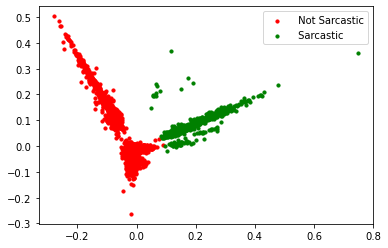

In [18]:
# plot the results 
colors = ['red', 'green'] 
cluster = ['Not Sarcastic','Sarcastic'] 
for i in range(num_clusters): 
	plt.scatter(reduced_data[kmeans.labels_ == i, 0], 
				reduced_data[kmeans.labels_ == i, 1], 
				s=10, color=colors[i], 
				label=f' {cluster[i]}') 
plt.legend() 
plt.show()